# Distribution of local maxima in a Gaussian Random Field

In this notebook, I apply the distribution of local maxima of Cheng & Schwartzman.  I reproduce the figure with the distribution in 1D, 2D and 3D and then check how much the distribution fits with simulated data.

## Check code for peak distribution of Cheng&Schwartzman 

1. Below I defined the formulae of Cheng&Schwartzman in arXiv:1503.01328v1.  On page 3.3 the density functions are displayed for 1D, 2D and 3D. 
2. Consequently, I apply these formulae to a range of x-values, which reproduces Figure 1.

In [2]:
% matplotlib inline
import numpy as np
import math
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
from nipy.labs.utils.simul_multisubject_fmri_dataset import surrogate_3d_dataset
import palettable.colorbrewer as cb
from nipype.interfaces import fsl
import os
import pandas as pd

#### Define formulae

In [3]:
def peakdens1D(x,k):
    f1 = (3-k**2)**0.5/(6*math.pi)**0.5*np.exp(-3*x**2/(2*(3-k**2)))
    f2 = 2*k*x*math.pi**0.5/6**0.5*stats.norm.pdf(x)*stats.norm.cdf(k*x/(3-k**2)**0.5)
    out = f1+f2
    return out

def peakdens2D(x,k):
    f1 = 3**0.5*k**2*(x**2-1)*stats.norm.pdf(x)*stats.norm.cdf(k*x/(2-k**2)**0.5)
    f2 = k*x*(3*(2-k**2))**0.5/(2*math.pi) * np.exp(-x**2/(2-k**2))
    f31 = 6**0.5/(math.pi*(3-k**2))**0.5*np.exp(-3*x**2/(2*(3-k**2)))
    f32 = stats.norm.cdf(k*x/((3-k**2)*(2-k**2))**0.5)
    out = f1+f2+f31*f32
    return out

def peakdens3D(x,k):
    fd1 = 144*stats.norm.pdf(x)/(29*6**(0.5)-36)
    fd211 = k**2.*((1.-k**2.)**3. + 6.*(1.-k**2.)**2. + 12.*(1.-k**2.)+24.)*x**2. / (4.*(3.-k**2.)**2.)
    fd212 = (2.*(1.-k**2.)**3. + 3.*(1.-k**2.)**2.+6.*(1.-k**2.)) / (4.*(3.-k**2.))
    fd213 = 3./2.
    fd21 = (fd211 + fd212 + fd213)
    fd22 = np.exp(-k**2.*x**2./(2.*(3.-k**2.))) / (2.*(3.-k**2.))**(0.5)
    fd23 = stats.norm.cdf(2.*k*x / ((3.-k**2.)*(5.-3.*k**2.))**(0.5))
    fd2 = fd21*fd22*fd23
    fd31 = (k**2.*(2.-k**2.))/4.*x**2. - k**2.*(1.-k**2.)/2. - 1.
    fd32 = np.exp(-k**2.*x**2./(2.*(2.-k**2.))) / (2.*(2.-k**2.))**(0.5)
    fd33 = stats.norm.cdf(k*x / ((2.-k**2.)*(5.-3.*k**2.))**(0.5))
    fd3 = fd31 * fd32 * fd33
    fd41 = (7.-k**2.) + (1-k**2)*(3.*(1.-k**2.)**2. + 12.*(1.-k**2.) + 28.)/(2.*(3.-k**2.))
    fd42 = k*x / (4.*math.pi**(0.5)*(3.-k**2.)*(5.-3.*k**2)**0.5)
    fd43 = np.exp(-3.*k**2.*x**2/(2.*(5-3.*k**2.)))
    fd4 = fd41*fd42 * fd43
    fd51 = math.pi**0.5*k**3./4.*x*(x**2.-3.)
    f521low = np.array([-10.,-10.])
    f521up = np.array([0.,k*x/2.**(0.5)])
    f521mu = np.array([0.,0.])
    f521sigma = np.array([[3./2., -1.],[-1.,(3.-k**2.)/2.]])
    fd521,i = stats.mvn.mvnun(f521low,f521up,f521mu,f521sigma) 
    f522low = np.array([-10.,-10.])
    f522up = np.array([0.,k*x/2.**(0.5)])
    f522mu = np.array([0.,0.])
    f522sigma = np.array([[3./2., -1./2.],[-1./2.,(2.-k**2.)/2.]])
    fd522,i = stats.mvn.mvnun(f522low,f522up,f522mu,f522sigma) 
    fd5 = fd51*(fd521+fd522)
    out = fd1*(fd2+fd3+fd4+fd5)
    return out

#### Apply formulae to a range of x-values 

In [4]:
xs = np.arange(-4,4,0.01).tolist()
ys_3d_k01 = []
ys_3d_k05 = []
ys_3d_k1 = []
ys_2d_k01 = []
ys_2d_k05 = []
ys_2d_k1 = []
ys_1d_k01 = []
ys_1d_k05 = []
ys_1d_k1 = []


for x in xs:
    ys_1d_k01.append(peakdens1D(x,0.1))
    ys_1d_k05.append(peakdens1D(x,0.5))
    ys_1d_k1.append(peakdens1D(x,1))
    ys_2d_k01.append(peakdens2D(x,0.1))
    ys_2d_k05.append(peakdens2D(x,0.5))
    ys_2d_k1.append(peakdens2D(x,1))
    ys_3d_k01.append(peakdens3D(x,0.1))
    ys_3d_k05.append(peakdens3D(x,0.5))
    ys_3d_k1.append(peakdens3D(x,1))


#### Figure 1 from paper 

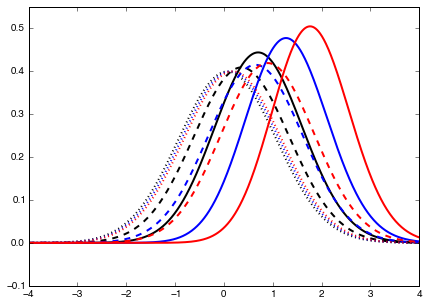

In [5]:
plt.figure(figsize=(7,5))
plt.plot(xs,ys_1d_k01,color="black",ls=":",lw=2)
plt.plot(xs,ys_1d_k05,color="black",ls="--",lw=2)
plt.plot(xs,ys_1d_k1,color="black",ls="-",lw=2)
plt.plot(xs,ys_2d_k01,color="blue",ls=":",lw=2)
plt.plot(xs,ys_2d_k05,color="blue",ls="--",lw=2)
plt.plot(xs,ys_2d_k1,color="blue",ls="-",lw=2)
plt.plot(xs,ys_3d_k01,color="red",ls=":",lw=2)
plt.plot(xs,ys_3d_k05,color="red",ls="--",lw=2)
plt.plot(xs,ys_3d_k1,color="red",ls="-",lw=2)
plt.ylim([-0.1,0.55])
plt.show()

## Apply the distribution to simulated data 

I now simulate random field, extract peaks with FSL and compare these simulated peaks with the theoretical distribution.

In [6]:
os.chdir("/Users/Joke/Documents/Onderzoek/Studie_7_neuropower_improved/WORKDIR/")

sm=1
smooth_FWHM = 3
smooth_sd = smooth_FWHM/(2*math.sqrt(2*math.log(2)))
data = surrogate_3d_dataset(n_subj=1,sk=smooth_sd,shape=(500,500,500),noise_level=1)
minimum = data.min()
newdata = data - minimum #little trick because fsl.model.Cluster ignores negative values
img=nib.Nifti1Image(newdata,np.eye(4))
img.to_filename(os.path.join("RF_"+str(sm)+".nii.gz"))
cl=fsl.model.Cluster()
cl.inputs.threshold = 0
cl.inputs.in_file=os.path.join("RF_"+str(sm)+".nii.gz")
cl.inputs.out_localmax_txt_file=os.path.join("locmax_"+str(sm)+".txt")
cl.inputs.num_maxima=10000000
cl.inputs.connectivity=26
cl.inputs.terminal_output='none'
cl.run()


In [7]:
peaks = pd.read_csv("locmax_"+str(1)+".txt",sep="\t").drop('Unnamed: 5',1)
peaks.Value = peaks.Value + minimum

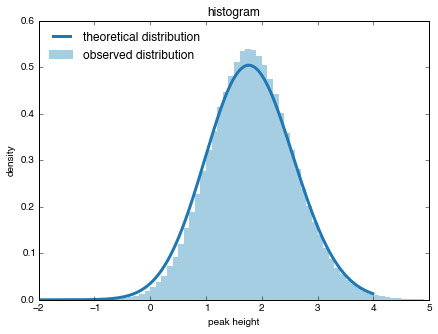

In [175]:
twocol = cb.qualitative.Paired_12.mpl_colors
plt.figure(figsize=(7,5))
plt.hist(peaks.Value,lw=0,facecolor=twocol[0],normed=True,bins=np.arange(-5,5,0.1),label="observed distribution")
plt.xlim([-2,5])
plt.ylim([0,0.6])
plt.plot(xs,ys_3d_k1,color=twocol[1],lw=3,label="theoretical distribution")
plt.title("histogram")
plt.xlabel("peak height")
plt.ylabel("density")
plt.legend(loc="upper left",frameon=False)
plt.show()

In [176]:
peaks[1:5]

,Cluster Index,Value,x,y,z
1,1,6.541821,0,83,193
2,1,6.441821,499,132,458
3,1,6.241821,0,144,82
4,1,6.141821,358,199,499


In [192]:
ss = 10000
smpl = np.random.choice(len(peaks),ss,replace=False)
peaksmpl = peaks.loc[smpl].reset_index()

In [193]:
dist = []
diff = []

for p in range(ss):
    for q in range(p+1,ss):
        xd = peaksmpl.x[q]-peaksmpl.x[p]
        yd = peaksmpl.y[q]-peaksmpl.y[p]
        zd = peaksmpl.z[q]-peaksmpl.z[p]
        if not any(x > 20 or x < -20 for x in [xd,yd,zd]):
            dist.append(np.sqrt(xd**2+yd**2+zd**2))
            diff.append(abs(peaksmpl.Value[p]-peaksmpl.Value[q]))


In [200]:
mn = []
ds = np.arange(start=2,stop=100,step=2)
for d in ds:
    mn.append(np.mean(np.array(diff)[2*np.round(np.array(dist)/2)==d]))

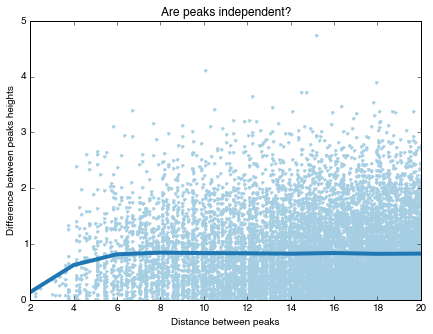

In [202]:
twocol = cb.qualitative.Paired_12.mpl_colors
plt.figure(figsize=(7,5))
plt.plot(dist,diff,"r.",color=twocol[0],linewidth=0)
#plt.hist(peaks.Value,lw=0,facecolor=twocol[0],normed=True,bins=np.arange(-5,5,0.1),label="observed distribution")
plt.xlim([2,20])
#plt.ylim([0,0.6])
plt.plot(ds,mn,color=twocol[1],lw=4)
plt.title("Are peaks independent?")
plt.xlabel("Distance between peaks")
plt.ylabel("Difference between peaks heights")
#plt.legend(loc="upper left",frameon=False)
plt.show()